In [42]:
import os
import datetime
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [43]:
# Lecture du fichier d'environnement
ENV_FILE = '/home/albane/Cours/Projet Corona/env.yaml'

with open(ENV_FILE) as f:
    params = yaml.load(f) #, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR,
                         params['directories']['processed'],
                         params['files']['all_data'])

# Lecture du fichier de données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=['Last Update'])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df['day'] <= datetime.date(2020, 3, 20)]
              )

/home/albane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


## Choix du pays et de la population

In [44]:
country = "South Korea"

In [45]:
country_population = 57000

## Optimization des paramètres beta et gamma en fonction de la population

In [ ]:
def get_country(country):
    epidemie_agg = epidemie_df[epidemie_df['Country/Region'] == country].groupby(['Country/Region', 'day']).agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'}).reset_index()
    epidemie_agg['infected'] = epidemie_agg['Confirmed'].diff()
    return(epidemie_agg)

In [47]:
infected_population = get_country(country)['infected']
nb_steps = len(infected_population)

In [48]:
def sumsq_error(parameters):
    beta, gamma = parameters
    
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

    solution = solve_ivp(SIR, [0, nb_steps-1], [country_population, 1, 0], t_eval=np.arange(0, nb_steps, 1))
    
    return(sum((solution.y[1]-infected_population)**2))

In [49]:
msol = minimize(sumsq_error, [0.001, 0.1], method='Nelder-Mead')
beta, gamma = msol.x

## Graphe des prévisions du modèle avec les paramètres optimisés

In [50]:
solution = solve_ivp(SIR, [0, 40], [country_population, 1, 0], t_eval=np.arange(0, 40, 1))

In [51]:
def plot_epidemia(solution, infected, susceptible=False):
    fig = plt.figure(figsize=(12, 5))
    if susceptible:
        plt.plot(solution.t, solution.y[0])
    plt.plot(solution.t, solution.y[1])
    plt.plot(solution.t, solution.y[2])
    plt.plot(infected.reset_index(drop=True).index, infected, "k*:")
    plt.grid("True")
    if susceptible:
        plt.legend(["Susceptible", "Infected", "Recovered", "Original Data"])
    else:
        plt.legend(["Infected", "Recovered", "Original Data"])
    plt.show()

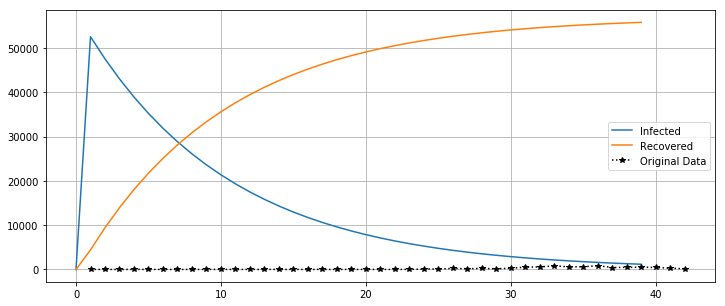

In [52]:
plot_epidemia(solution, get_country(country)['infected'])